<a href="https://colab.research.google.com/github/Cola0912/3dp-webcam-detection/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# カメラを使った3Dプリンターの印刷失敗検知機能の実装 　　実験用

初期設定

In [42]:
!pip install opencv-python-headless
from google.colab import drive
drive.mount('/content/drive')

import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

# 外部関数を変更した時のためにキャッシュを参考にしない
%reload_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


googleドライブから実験用画像データを持ってくる

その際、OpenCVとMatplotlibとで色空間の扱いが異なるため変換を行う

画像の読み込みに成功しました。


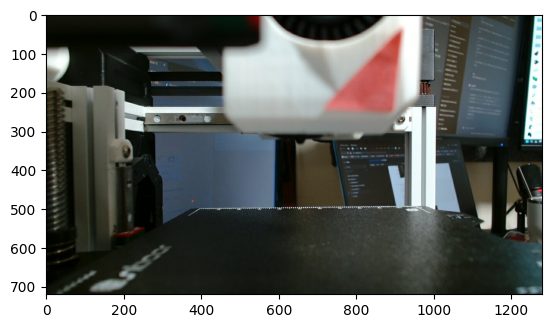

In [33]:
image_path = '/content/drive/MyDrive/3dp-webcam-detection/testpicturs/25-60-30.jpg'
image = cv2.imread(image_path)
if image is None:
    print("画像の読み込みに失敗しました。ファイルパスを確認してください。")
else:
    print("画像の読み込みに成功しました。")

# OpenCVとpltで色空間の扱いが異なる。
# OpenCV : BGR
# matplotlib : RGB
# BGRからRGBに変換
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# RGB画像を表示
plt.imshow(image_rgb)
plt.show()

この後の処理を行いやすくするために画像を少し加工する。

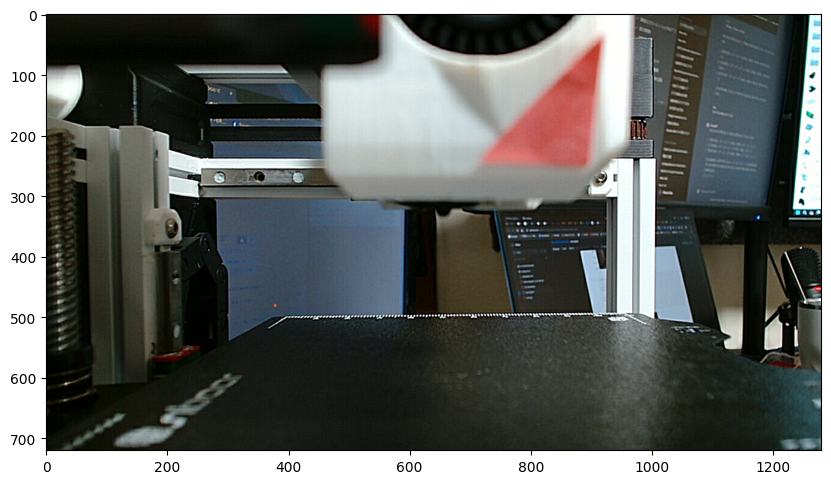

In [34]:
# ノイズ軽減のためのガウシアンぼかし
# (5, 5) はぼかしのためのカーネルサイズ、0 は標準偏差を自動的に計算するための値
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

# 先鋭化のためのカーネルを定義
sharpen_kernel = np.array([[-1, -1, -1],
                           [-1, 9, -1],
                           [-1, -1, -1]])

# 先鋭化フィルタの適用
sharpened_image = cv2.filter2D(blurred_image, -1, sharpen_kernel)

# 結果の表示
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2RGB))
plt.show()

色範囲の指定

In [36]:
gray_image = cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2GRAY)
hsv_image = cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2HSV)

_, binary_image = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)
#adaptive_thresh = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# 青色の範囲を定義
lower_blue = np.array([110, 50, 50])
upper_blue = np.array([130, 255, 255])


# 色相の低い側の赤色範囲
lower_red1 = np.array([0, 100, 100])
upper_red1 = np.array([10, 255, 255])

# 色相の高い側の赤色範囲
lower_red2 = np.array([160, 100, 100])
upper_red2 = np.array([180, 255, 255])



マスクと二値化

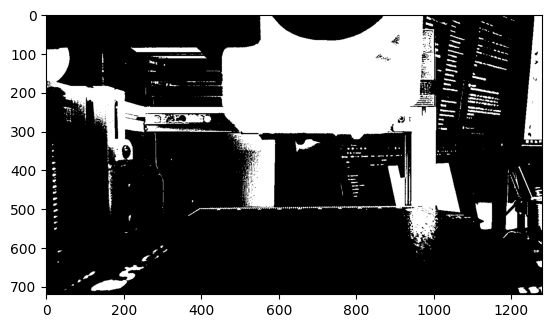

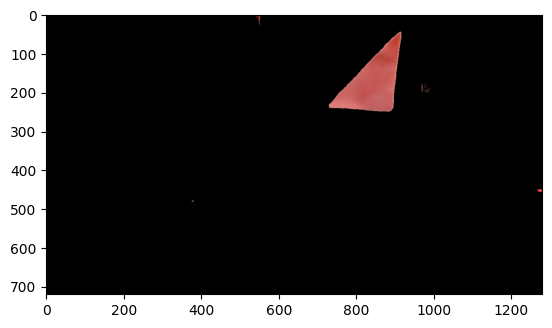

In [37]:
# 青色のみマスク
#blue_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)

# 二値化画像の生成
#blue_binary_image = cv2.bitwise_and(image, image, mask=blue_mask)

# HSV色空間に変換
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# 赤色部分のみマスク
red_mask1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
red_mask2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
red_mask = cv2.bitwise_or(red_mask1, red_mask2)

# 二値化画像の生成
red_binary_image = cv2.bitwise_and(image, image, mask=red_mask)

plt.imshow(binary_image, cmap='gray')
plt.show()

#plt.imshow(cv2.cvtColor(blue_binary_image, cv2.COLOR_BGR2RGB))
#plt.show()

plt.imshow(cv2.cvtColor(red_binary_image, cv2.COLOR_BGR2RGB))
plt.show()

輪郭検出

このとき一番大きい輪郭を結果に反映。それ以外は無視する。

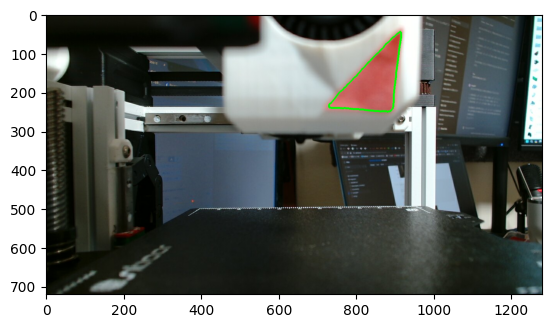

In [38]:
# ここでred_maskは既にバイナリ画像（単一チャンネル）
# このマスクを使って輪郭を検出する
contours, hierarchy = cv2.findContours(red_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# 一番大きい輪郭を見つける
largest_contour = max(contours, key=cv2.contourArea)

# 一番大きい輪郭のみを元の画像に描画する
contour_image = image.copy()
cv2.drawContours(contour_image, [largest_contour], -1, (0, 255, 0), 3)

# 描画された輪郭を表示する
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.show()


輪郭の近似を行い三角形を検出

677.7543950080872


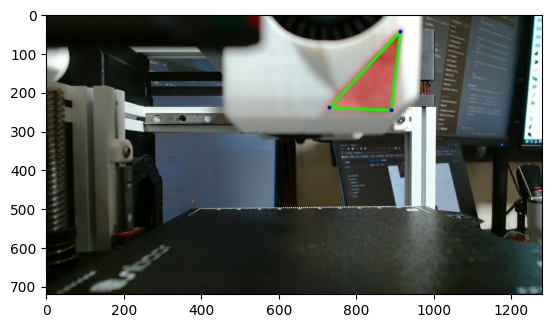

In [39]:
# 輪郭の周囲長を計算
perimeter = cv2.arcLength(largest_contour, True)
print(perimeter)

# 輪郭の近似を行う
approximation = cv2.approxPolyDP(largest_contour, 0.1 * perimeter, True)

# 近似された頂点の数が3の場合、三角形とみなす
if len(approximation) == 3:
    # 三角形の輪郭を描画
    cv2.drawContours(image, [approximation], 0, (0, 255, 0), 5)
    # 三角形の頂点を描画
    for point in approximation:
        cv2.circle(image, tuple(point[0]), 5, (255, 0, 0), -1)




# 結果の画像を表示する
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

三角形の頂点間の距離から一番長い辺の長さを求める

In [40]:
# 頂点間の距離を計算する関数 頂点座標からユークリッド距離で計算
def calculate_distance(point1, point2):
    return np.sqrt((point2[0] - point1[0]) ** 2 + (point2[1] - point1[1]) ** 2)

# 三角形の各辺の長さを計算
edge_lengths = [calculate_distance(approximation[i][0], approximation[(i+1) % 3][0]) for i in range(3)]

# 一番長い辺を選択（または他の基準で辺を選択可能）
longest_edge = max(edge_lengths)
print("最長辺の長さ:", longest_edge)

最長辺の長さ: 267.4210163767986


三角形の重心からノズルの先端までのおおよその距離を以下の式(暫定)で計算。


ただしこの式では、奥行き方向でのオフセット距離計算にしか対応していないので、プリンターヘッドが機械座標系のY軸方向に移動すると画像内のｘオフセット量がずれる。要変更。


$$
offset_x = min\_offset_x + \frac{(max\_offset_x - min\_offset_x) \times (longest\_edge - min\_edge\_length)}{max\_edge\_length - min\_edge\_length}
$$
$$
offset_y = min\_offset_y + \frac{(max\_offset_y - min\_offset_y) \times (longest\_edge - min\_edge\_length)}{max\_edge\_length - min\_edge\_length}
$$


xオフセット量 :  -190.0
yオフセット量 :  150.0


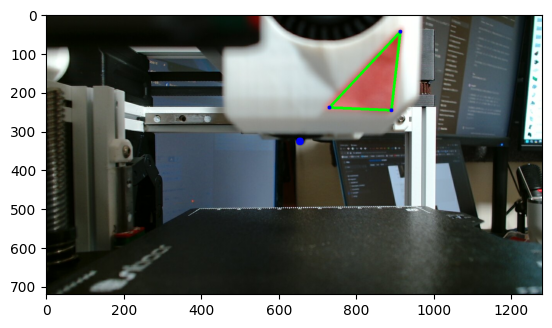

In [49]:
centroid = np.mean(approximation, axis=0, dtype=int)[0]
    # ノズルは三角形の印の直下にあると仮定してオフセットを決定します
    # オフセットの値(pixel)は任意で調整してください

### プリンター固有の値 #################################################################
    # 25-60-30.jpg  : -190,150    最長辺の長さ, 267.4210163767986
    # 45-60-30.jpg  : ???,???     計算で求める
    # 60-60-30.jpg  : ???,???
    # 110-60-30.jpg : -85,55      最長辺の長さ, 116.18089343777659

min_edge_length = 116.18089343777659
max_edge_length = 267.4210163767986
max_offset_x    = -190
min_offset_x    = -85
max_offset_y    = 150
min_offset_y    = 55
########################################################################################

offset_x = min_offset_x + (max_offset_x - min_offset_x) * (longest_edge - min_edge_length) / (max_edge_length - min_edge_length)
offset_y = min_offset_y + (max_offset_y - min_offset_y) * (longest_edge - min_edge_length) / (max_edge_length - min_edge_length)

print('xオフセット量 : ', offset_x)
print('yオフセット量 : ', offset_y)

nozzle_offset_x = offset_x # -190
nozzle_offset_y = offset_y # 150

nozzle_image = image.copy()

    # ノズルの位置をマーク 小数点以下を切り捨ててオフセット値を足す
nozzle_position = (centroid[0]+math.floor(nozzle_offset_x), centroid[1] + math.floor(nozzle_offset_y))
cv2.circle(nozzle_image, nozzle_position, 10, (255, 0, 0), -1)

# マークされた画像を表示
plt.imshow(cv2.cvtColor(nozzle_image, cv2.COLOR_BGR2RGB))
plt.show()
